In [1]:
import json
import ast
import pandas as pd
import numpy as np
import scipy as sp

In [2]:
def parse(path):
  g = open(path, 'r')
  for l in g:
    yield eval(l)

In [3]:
# dct = {'user':[],'item':[],'totaltime':[],'twoweektime':[]} 
data = []
counter = 0
for i in parse("australian_users_items.json"):
    dump = json.dumps(i)   
    load = json.loads(dump)
    counter += 1
    if counter%10000 == 0:
        print(counter)
    for i in range(load['items_count']):
        observation = [load['steam_id'],load['items'][i]['item_id'],load['items'][i]['playtime_forever'],load['items'][i]['playtime_2weeks'],1]
        data.append(observation)


10000
20000
30000
40000
50000
60000
70000
80000


In [4]:
df = pd.DataFrame(data)
df.columns = ['steam_id', 'item_id','playtime_forever','playtime_2weeks','isplayd']
df.describe()

,playtime_forever,playtime_2weeks,isplayd
count,5.153209e+06,5.153209e+06,5153209.0
mean,9.914951e+02,9.104707e+00,1.0
std,5.418204e+03,1.403926e+02,0.0
min,0.000000e+00,0.000000e+00,1.0
25%,0.000000e+00,0.000000e+00,1.0
50%,3.400000e+01,0.000000e+00,1.0
75%,3.550000e+02,0.000000e+00,1.0
max,6.427730e+05,1.996700e+04,1.0


In [6]:
# user_id = pd.factorize(df.steam_id)
# item_index = pd.factorize(df.item_id)
# steamid2userid = dict(zip(user_id[0],df.steam_id))
# itemid2itemindex = dict(zip(item_index[0],df.item_id))
# df['user_id'] = user_id[0]
# df['item_index'] = item_index[0]
# print(len(df.user_id.unique()))
# print(len(df.item_index.unique()))
# df.head()
df.to_pickle('user_item.pkl')

# Sample the data

In [104]:
# first we select 10000 user from a total of 70912 users
np.random.seed(200)
usersize = 20000
itemsize = 150
mypercent = 1
user_sample=np.random.choice(df.steam_id.unique(),replace=False,size=usersize)
item_sample = np.random.choice(df.item_id.unique(),replace = False,size = itemsize)
df_sample = df[df['steam_id'].isin(user_sample)]
df_sample = df_sample[df_sample['item_id'].isin(item_sample)]
# then we sample 70% user item pairs base on user
df_sample=df_sample.groupby('steam_id').apply(lambda x: x.sample(int(len(x)*mypercent),random_state=100)).copy().reset_index(drop=True)

df_sample = df_sample[['steam_id','item_id','isplayd']]

# since in a matrix factorization algorithm, we can not recommand outside of the item list,and first we want to make a mapping
user_id = pd.factorize(df_sample.steam_id)
item_index = pd.factorize(df_sample.item_id)
steamid2userid = dict(zip(user_id[0],df_sample.steam_id))
itemid2itemindex = dict(zip(item_index[0],df_sample.item_id))
df_sample['user_id'] = user_id[0]
df_sample['item_index'] = item_index[0]
print(len(df_sample.user_id.unique()))
print(len(df_sample.item_index.unique()))
#df_sample.head(n=20)
# df_sample.sort_values(by = ['user_id','item_insamples'])

10692
130


In [105]:
df_sample = df_sample[['user_id','item_index','isplayd']]
print(len(df_sample['user_id'].unique().tolist()))
print(len(df_sample['item_index'].unique().tolist()))

10692
130


# Convert the user_item pair into sparse matrix

In [106]:
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
df_sample['user_id'] = df_sample['user_id'].astype("category")
df_sample['item_index'] = df_sample['item_index'].astype("category")

In [107]:
user_item_isplayd = coo_matrix((df_sample['isplayd'].astype(float), 
                   (df_sample['user_id'].cat.codes, 
                    df_sample['item_index'].cat.codes)))

In [108]:
user_item_isplayd

<10692x130 sparse matrix of type '<class 'numpy.float64'>'
	with 26592 stored elements in COOrdinate format>

In [109]:
# check if the sparse matrix matches our expection
# i.e. every row has nonzero entrances corresponds to one user's all the buyed-itemes
user_item_isplayd_matrix = user_item_isplayd.toarray()
np.nonzero(user_item_isplayd_matrix[4])

(array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),)

In [110]:
# hyper-parameter
# latent dimension of matrix factorization
latent_dimension = 50
user_factors, _, item_factors = svds(user_item_isplayd, latent_dimension)

In [111]:
print(item_factors.shape)
print(user_factors.shape)

(50, 130)
(10692, 50)


In [112]:
# a = np.asmatrix(user_factors[4])
# a.shape

In [113]:
# b = np.dot(a,item_factors)
# print(b.shape)
# b

In [114]:
# choose the top 20 score of the items
# c = np.array(b)
# c = set(c.argsort().ravel()[-20:][::-1])
# c

# cross-validation set up

In [115]:
# df_sample.head()

In [124]:
# for this project, I choose to implement a 5-fold cross validation 
seed = 4571
np.random.seed(seed)
# in all the df_sample, choose 90% for training, leave 10% for testing
df_train,df_test = np.split(df_sample.sample(frac=1),[int(.9*len(df_sample))])
m = len(df_train.index)
df_train_1,df_train_2,df_train_3,df_train_4,df_train_5 = np.split(df_train.sample(frac=1), [int(.2*m),int(.4*m),int(.6*m),int(0.8*m)])
validation_list = [df_train_1,df_train_2,df_train_3,df_train_4,df_train_5]

# Evaluation( recall&precision )

In [141]:
def getmetrics(train,validation,latent_dimension=50):
    user_item_isplayd_train = coo_matrix((train['isplayd'].astype('float'), 
                   (train['user_id'].cat.codes, 
                    train['item_index'].cat.codes)))
    user_item_isplayd_train_matrix = user_item_isplayd_train.toarray()
    user_factors_train, _, item_factors_train = svds(user_item_isplayd_train, latent_dimension)
    recall = 0
    precision = 0
    users_validation = set(validation.user_id.unique())
    total = len(users_validation)
    for i in users_validation:
    
        a = np.asmatrix(user_factors_train[i])
        b = np.dot(a,item_factors_train)
        c = np.array(b)
        predict_i = set(c.argsort().ravel()[-10:][::-1]) #set of t recommended items for a user
        G_1 = set(np.flatnonzero(user_item_isplayd_matrix[i]).tolist()) # all the items related to the user
        G_2 = set(np.flatnonzero(user_item_isplayd_train_matrix[i]).tolist()) # all the items related to the user in trainset
    #     print(i)
        S = predict_i.difference(G_2) # relevant items in test set
        G = G_1.difference(G_2)
        recall_i = len(G.intersection(S))/len(G)
        if len(S) != 0:
            precision_i = len(G.intersection(S))/len(S)
        else:
            precision_i = 1
        recall += recall_i
        precision += precision_i

#     print(recall/total)
#     print(precision/total)
    return recall/total,precision/total

In [142]:
recalls = []
precisions = []
for i in range(5):
    validation_df = validation_list[i]
    train_df = df_train.append(validation_list[i]).drop_duplicates(keep=False)
    # since in a matrix factorization algorithm, we can not have user who do not have any training data   
#     train_df['user_id'] = train_df['user_id'].astype("category")
#     train_df['item_index'] = train_df['item_index'].astype("category")
    
    # data cleaning,make sure that validation set do not have entrys beyond the sparse matrix
    users = set(train_df.user_id.unique())
    items = set(train_df.item_index.unique())
    # print(len(users))
    # print(len(items))
    # print(df_test.count())
    validation_df = validation_df[validation_df['user_id'].isin(users)]
    validation_df = validation_df[validation_df['item_index'].isin(items)]
    # print(df_test.count())

    user_item_isplayd_train = coo_matrix((train_df['isplayd'].astype(float), 
                   (train_df['user_id'].cat.codes, 
                    train_df['item_index'].cat.codes)))
    recall, precision = getmetrics(train_df,validation_df,50)
    recalls.append(recall)
    precisions.append(precision)

In [143]:
print(np.mean(recalls))
print(np.mean(precisions))

0.0137831935728684
0.022083985637854586


# Hyper parameters
In this matrix factorization problem, the main hyper parameter is the latent dimension.  
I choose a list of (1,2,3,4,5,6,7,8,9,10,15,20) for the svd method.

In [144]:
latent_dimensions = [1,2,3,4,5,6,7,8,9,10,15,20]
recalls = []
precisions = []

for latent_dimension in latent_dimensions:
    recalls_within = 0
    precisions_within = 0
    for i in range(5):
        validation_df = validation_list[i]
        train_df = df_train.append(validation_list[i]).drop_duplicates(keep=False)
        # since in a matrix factorization algorithm, we can not have user who do not have any training data   
        # data cleaning,make sure that validation set do not have entrys beyond the sparse matrix
        users = set(train_df.user_id.unique())
        items = set(train_df.item_index.unique())

        validation_df = validation_df[validation_df['user_id'].isin(users)]
        validation_df = validation_df[validation_df['item_index'].isin(items)]
    

        user_item_isplayd_train = coo_matrix((train_df['isplayd'].astype(float), (train_df['user_id'].cat.codes, train_df['item_index'].cat.codes)))


        recall, precision = getmetrics(train_df,validation_df,latent_dimension)
        recalls_within += recall
        precisions_within += precision
    
    recalls_within = recalls_within/5
    precisions_within = precisions_within/5
    print(recalls_within)
    print(precisions_within)
    
    recalls.append(recalls_within)
    precisions.append(precisions_within)
    


0.7010563940044297
0.13612468889455362
0.5740492206110036
0.11330290336208124
0.5304597613719414
0.10915434475562139
0.3672669685993041
0.08209287804639505
0.3454686708867595
0.07899514422260219
0.31284674332376433
0.07458735348374676
0.2960959936372728
0.0722502748704732
0.26009849425663434
0.06581213868877209
0.22463246997642652
0.05848411889207711
0.20310968182474465
0.05372466907724479
0.060333401748891236
0.020735017565034933
0.04402783744715059
0.019639372966563838


In [145]:
print(recalls)
print(precisions)

[0.7010563940044297, 0.5740492206110036, 0.5304597613719414, 0.3672669685993041, 0.3454686708867595, 0.31284674332376433, 0.2960959936372728, 0.26009849425663434, 0.22463246997642652, 0.20310968182474465, 0.060333401748891236, 0.04402783744715059]
[0.13612468889455362, 0.11330290336208124, 0.10915434475562139, 0.08209287804639505, 0.07899514422260219, 0.07458735348374676, 0.0722502748704732, 0.06581213868877209, 0.05848411889207711, 0.05372466907724479, 0.020735017565034933, 0.019639372966563838]


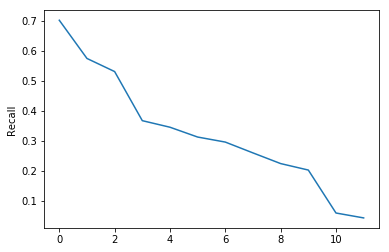

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(recalls)
plt.ylabel('Recall')
plt.show()

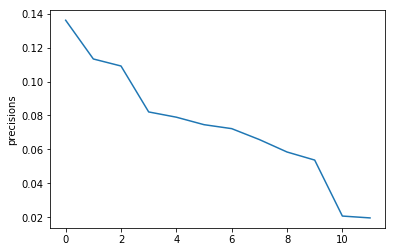

In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(precisions)
plt.ylabel('precisions')
plt.show()

during test, our model performs the best when latent_parameter = 2